Jaume Sánchez Salazar

# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you):
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

You have to report all your work at the end of this notebook.



# Code

In [ ]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """

    # Train the model
    history=model.fit(X_train, y_train,
                      validation_split= 0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)  #we put and underscore when we are not interested in the first variable returned by the function
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()


def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [ ]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 178s 2s/step - loss: 2.9679 - accuracy: 0.0529 - val_loss: 2.9483 - val_accuracy: 0.0560
Epoch 2/150
18/18 [==============================] - 5s 261ms/step - loss: 2.9457 - accuracy: 0.0553 - val_loss: 2.9447 - val_accuracy: 0.0546
Epoch 3/150
18/18 [==============================] - 5s 259ms/step - loss: 2.9399 - accuracy: 0.0623 - val_loss: 2.9373 - val_accuracy: 0.0703
Epoch 4/150
18/18 [==============================] - 5s 267ms/step - loss: 2.9301 - accuracy: 0.0737 - val_loss: 2.9270 - val_accuracy: 0.0746
Epoch 5/150
18/18 [==============================] - 5s 256ms/step - loss: 2.9209 - accuracy: 0.0797 - val_loss: 2.9187 - val_accuracy: 0.0810
Epoch 6/150
18/18 [==============================] - 5s 263ms/step - loss: 2.9126 - accuracy: 0.0840 - val_loss: 2.9107 - val_accuracy: 0.0871
Epoch 7/150
18/18 [==============================] - 5s 256ms/step - loss: 2.9059 - accuracy: 0.0874 - val_loss: 2.9079 - val_accuracy: 0.0877


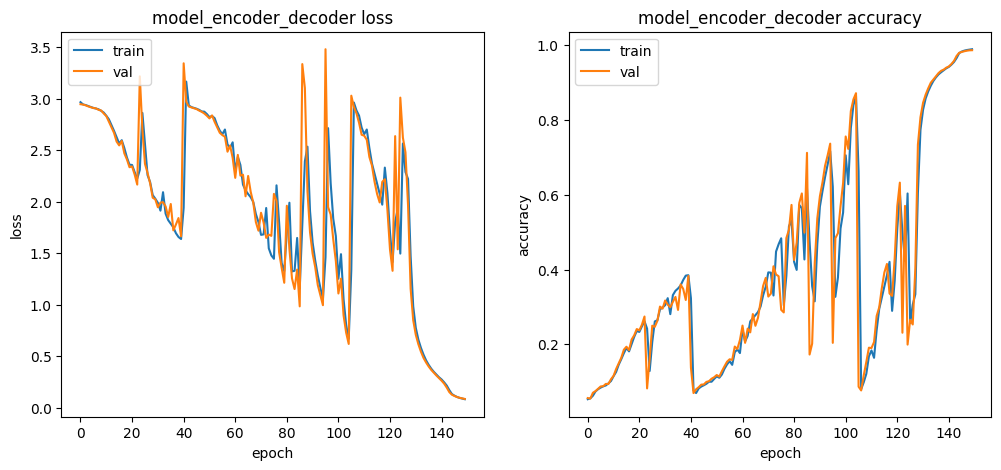

In [ ]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=100)

# Bahdanau and Luong General Attention classes

Let us implement the Bahdanau and Luong General Attention classes in order to do a comparative. Note that the code is quite similar to the previous one, LuongDotAttention.  A few changes such as initialization of weights and scores calculations are done.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        #Weights
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)

    def call(self, query, values):

      query_with_time_axis = tf.expand_dims(query,1)

      #Score
      score = self.v(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

      #Attention_weights shape == (batch_size, max_length, 1)
      attention_weights = tf.nn.softmax(score, axis=1)

      #context_vector shape after sum == (batch_size, hidden_size)
      context_vector = attention_weights * values
      context_vector = tf.reduce_sum(context_vector, axis=1)

      return(context_vector, attention_weights)

In [ ]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        #Weights
        self.W = tf.keras.layers.Dense(units)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        #Score
        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])

        #attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return(context_vector, attention_weights)

We change the original given function *build_attention_model* as given but now returning more variables: encoder_lstm, decoder_lstm, decoder_dense to plot the weighted matrix.

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # Create the context vector by applying attention to
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return(model, encoder_lstm, decoder_lstm, decoder_dense)

Inspired in the previous function, we create a similar one to visualize the attention weights.

In [ ]:
def plot_build_attention_model(inv_seq, encoder_lstm, decoder_lstm, decoder_dense, attention):

  #Let us create the attention_plot variable
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  #One hot encoding to the input sequence
  seq = one_hot_encode(inv_seq,n_features)

  #ENCODER STEP

  #Parameters are already given
  encoder_inputs = np.array(seq)
  encoder_inputs = encoder_inputs.reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float64)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  #DECODER STEP

  all_outputs = []
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  #Decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):
      #Pay attention!
      #decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      #Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      #Store the attention weights to plot them
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      #Passing the concatenated vector to the LSTM
      #Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      #Use the last hidden state for prediction the output
      #save the current prediction
      #we will concatenate all predictions later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      #Reinject the output (prediction) as inputs for the next loop iteration
      #as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  #One hot decoding
  seq_out=one_hot_decode(decoder_outputs[0])

  return(inv_seq, seq_out, attention_plot)

In [ ]:
import matplotlib.ticker as ticker
import numpy as np

def plot_attention(attention_plot, seq_in, seq_out):
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111)
  inverted_attention = np.flipud(attention_plot)

  ax.matshow(inverted_attention)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.set_xticklabels([''] + seq_in, fontdict = {'fontsize': 8})
  ax.set_yticklabels([''] + seq_out, fontdict = {'fontsize': 8})
  plt.show()
  return

In [ ]:
def final_plot(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = plot_build_attention_model(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)
  return

Once we have all the information ready to plot, let us see the performance of all the three algorithms.

In [ ]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

## Bahdanau

Epoch 1/200
18/18 [==============================] - 206s 3s/step - loss: 2.9675 - accuracy: 0.0535 - val_loss: 2.9472 - val_accuracy: 0.0546
Epoch 2/200
18/18 [==============================] - 14s 776ms/step - loss: 2.9449 - accuracy: 0.0569 - val_loss: 2.9433 - val_accuracy: 0.0574
Epoch 3/200
18/18 [==============================] - 14s 786ms/step - loss: 2.9403 - accuracy: 0.0644 - val_loss: 2.9374 - val_accuracy: 0.0701
Epoch 4/200
18/18 [==============================] - 14s 781ms/step - loss: 2.9331 - accuracy: 0.0716 - val_loss: 2.9277 - val_accuracy: 0.0745
Epoch 5/200
18/18 [==============================] - 14s 771ms/step - loss: 2.9221 - accuracy: 0.0777 - val_loss: 2.9187 - val_accuracy: 0.0800
Epoch 6/200
18/18 [==============================] - 14s 770ms/step - loss: 2.9128 - accuracy: 0.0824 - val_loss: 2.9107 - val_accuracy: 0.0843
Epoch 7/200
18/18 [==============================] - 14s 770ms/step - loss: 2.9055 - accuracy: 0.0861 - val_loss: 2.9038 - val_accuracy: 0

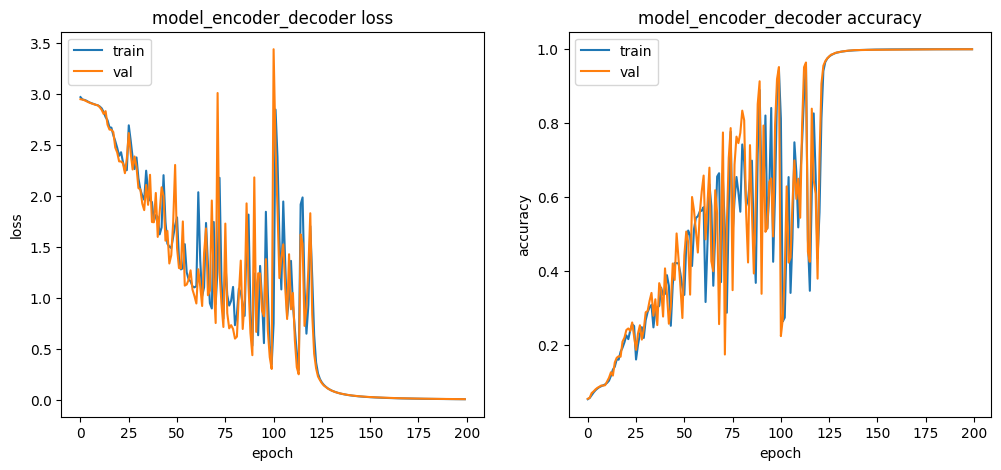

In [ ]:
attention = BahdanauAttention(rnn_units)
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

<ipython-input-10-b0446b3b356e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + seq_in, fontdict = {'fontsize': 8})
<ipython-input-10-b0446b3b356e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + seq_out, fontdict = {'fontsize': 8})


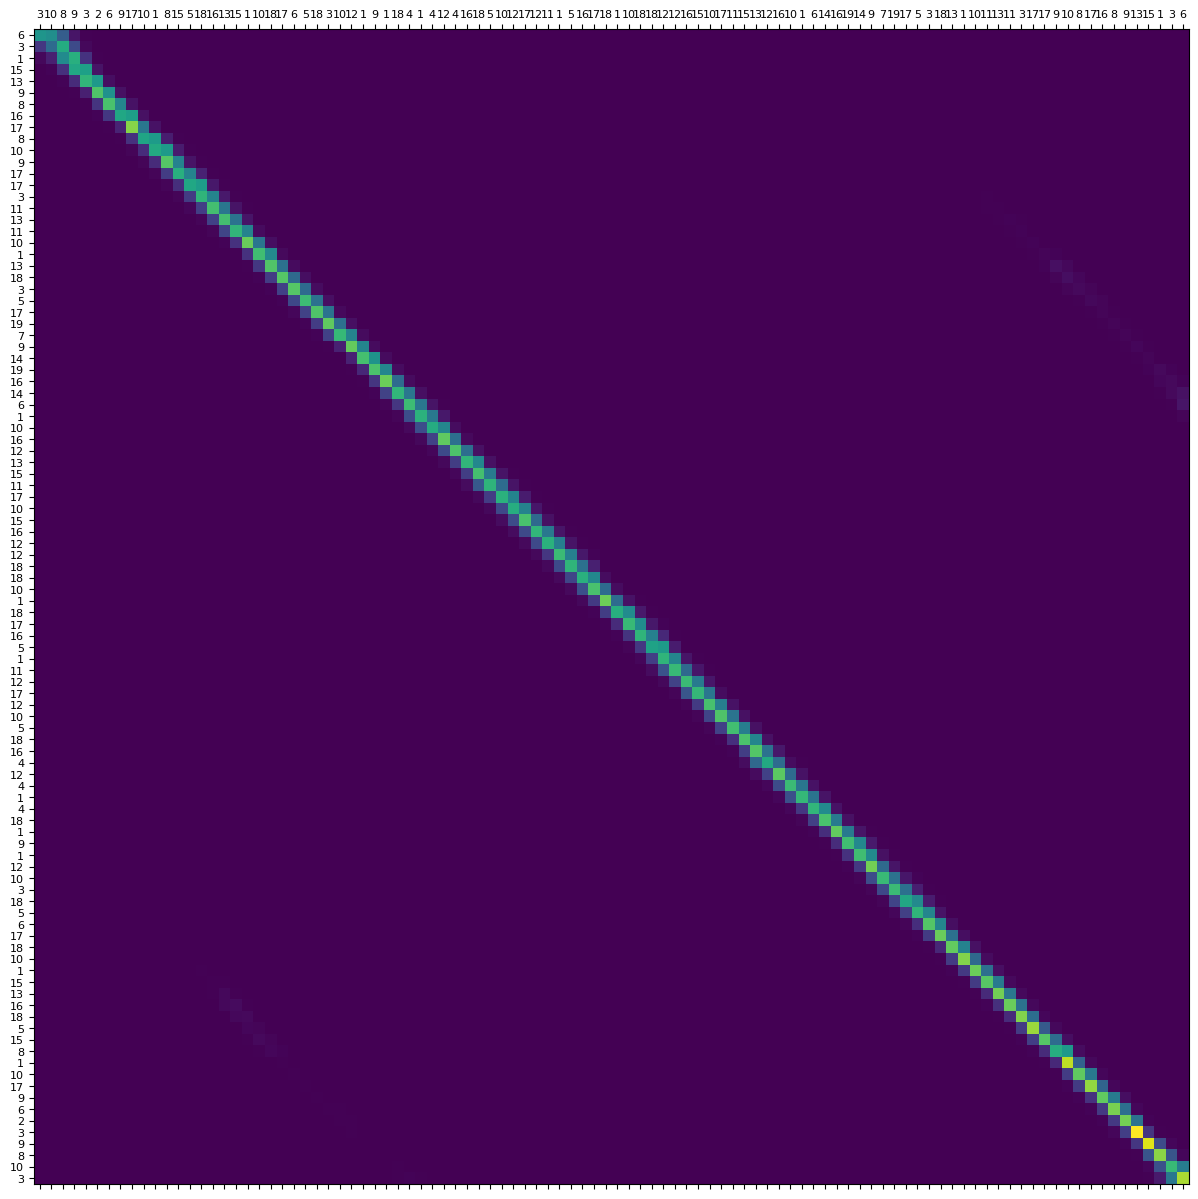

In [ ]:
inv_seq = generate_sequence(n_timesteps_in, n_features)
final_plot(inv_seq, encoder_lstm, decoder_lstm, decoder_dense, attention)

# Luong General

Epoch 1/200
18/18 [==============================] - 184s 3s/step - loss: 2.9638 - accuracy: 0.0530 - val_loss: 2.9468 - val_accuracy: 0.0561
Epoch 2/200
18/18 [==============================] - 12s 655ms/step - loss: 2.9450 - accuracy: 0.0569 - val_loss: 2.9437 - val_accuracy: 0.0537
Epoch 3/200
18/18 [==============================] - 12s 653ms/step - loss: 2.9412 - accuracy: 0.0643 - val_loss: 2.9425 - val_accuracy: 0.0584
Epoch 4/200
18/18 [==============================] - 12s 654ms/step - loss: 2.9328 - accuracy: 0.0724 - val_loss: 2.9377 - val_accuracy: 0.0694
Epoch 5/200
18/18 [==============================] - 12s 643ms/step - loss: 2.9215 - accuracy: 0.0795 - val_loss: 2.9126 - val_accuracy: 0.0849
Epoch 6/200
18/18 [==============================] - 12s 644ms/step - loss: 2.8966 - accuracy: 0.0929 - val_loss: 2.8824 - val_accuracy: 0.0985
Epoch 7/200
18/18 [==============================] - 12s 643ms/step - loss: 2.8727 - accuracy: 0.1016 - val_loss: 2.8726 - val_accuracy: 0

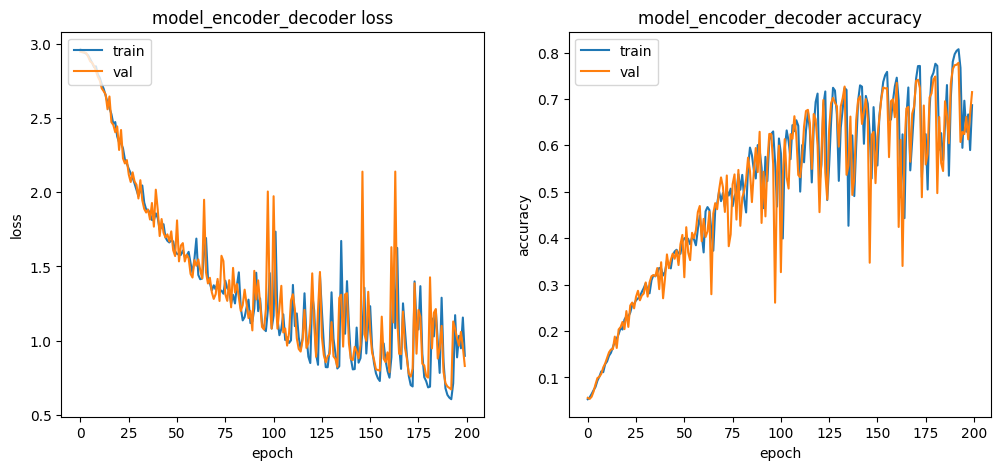

In [ ]:
attention = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

<ipython-input-12-b0446b3b356e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + seq_in, fontdict = {'fontsize': 8})
<ipython-input-12-b0446b3b356e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + seq_out, fontdict = {'fontsize': 8})


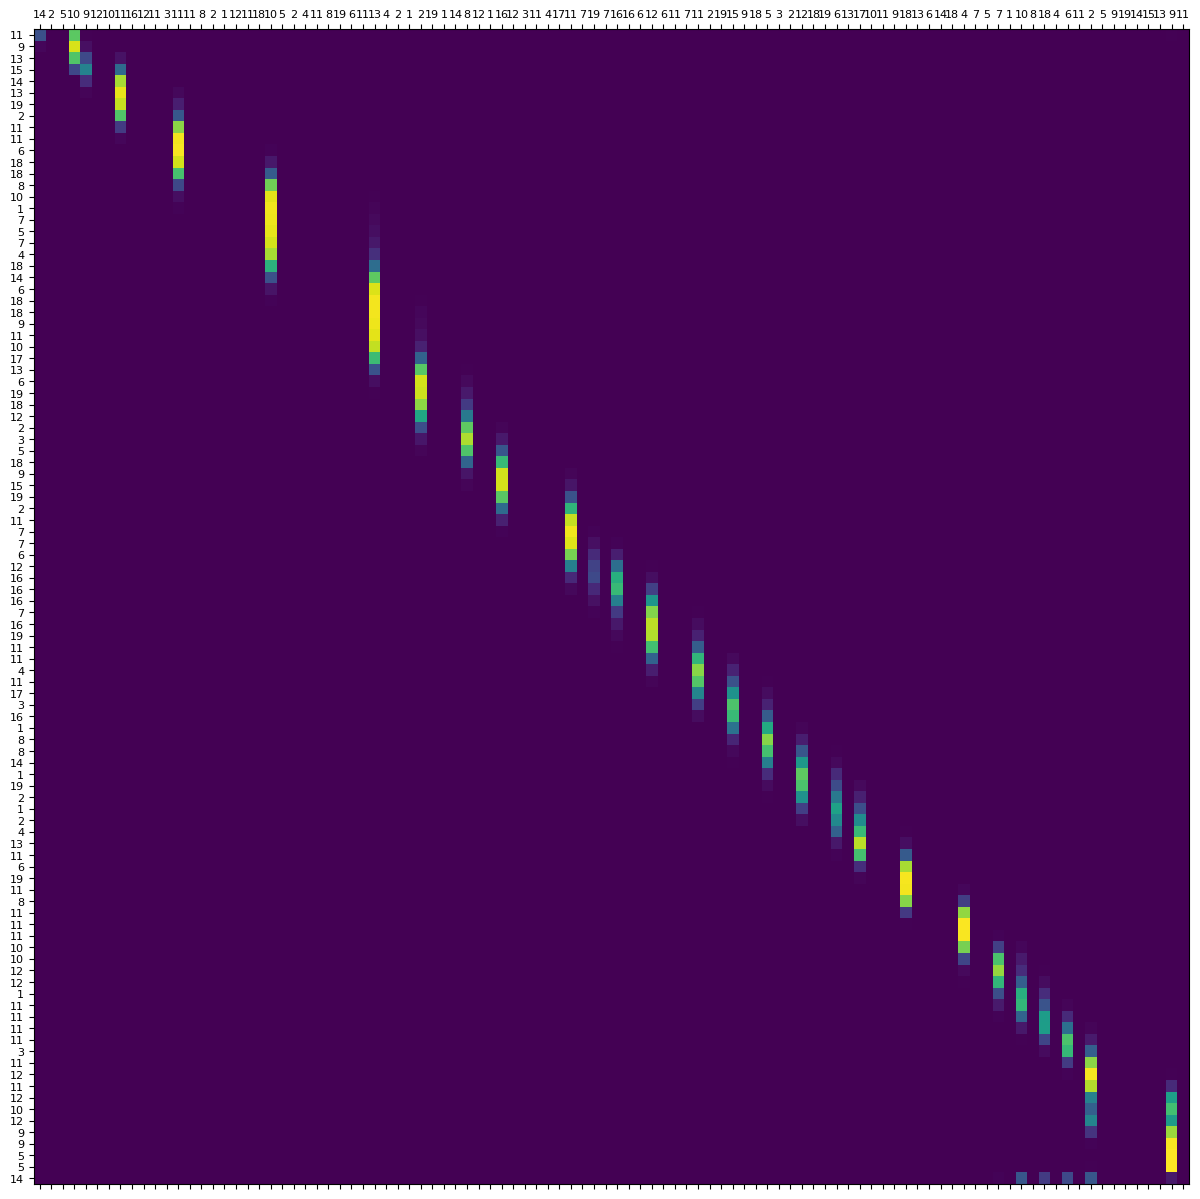

In [ ]:
inv_seq = generate_sequence(n_timesteps_in, n_features)
final_plot(inv_seq, encoder_lstm, decoder_lstm, decoder_dense, attention)

# Luong Dot

Let us repeat this method, but having the same epochs and patience than the other methods, in order to better compare.

Epoch 1/200
18/18 [==============================] - 172s 3s/step - loss: 2.9649 - accuracy: 0.0533 - val_loss: 2.9477 - val_accuracy: 0.0527
Epoch 2/200
18/18 [==============================] - 5s 262ms/step - loss: 2.9449 - accuracy: 0.0574 - val_loss: 2.9435 - val_accuracy: 0.0632
Epoch 3/200
18/18 [==============================] - 5s 263ms/step - loss: 2.9380 - accuracy: 0.0660 - val_loss: 2.9345 - val_accuracy: 0.0688
Epoch 4/200
18/18 [==============================] - 5s 255ms/step - loss: 2.9293 - accuracy: 0.0728 - val_loss: 2.9252 - val_accuracy: 0.0788
Epoch 5/200
18/18 [==============================] - 5s 254ms/step - loss: 2.9191 - accuracy: 0.0809 - val_loss: 2.9174 - val_accuracy: 0.0813
Epoch 6/200
18/18 [==============================] - 5s 264ms/step - loss: 2.9116 - accuracy: 0.0846 - val_loss: 2.9061 - val_accuracy: 0.0870
Epoch 7/200
18/18 [==============================] - 5s 262ms/step - loss: 2.9025 - accuracy: 0.0887 - val_loss: 2.8986 - val_accuracy: 0.0897


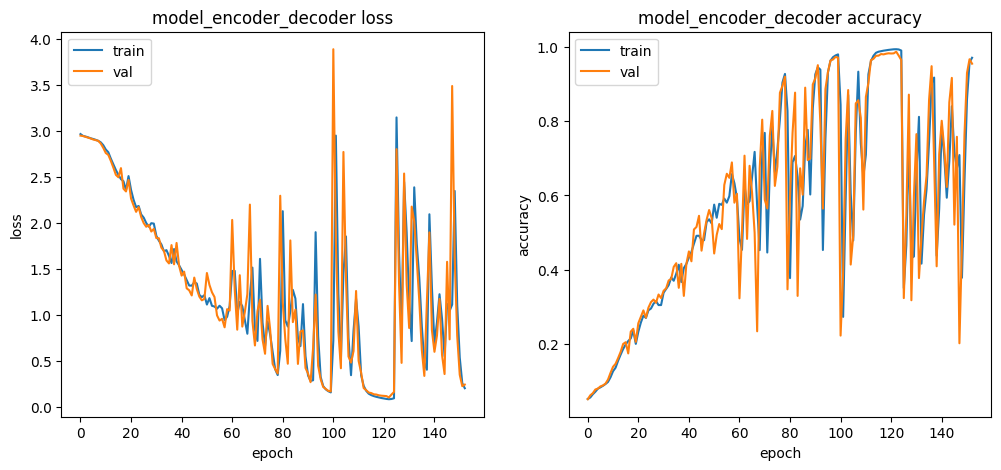

In [ ]:
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

<ipython-input-12-b0446b3b356e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + seq_in, fontdict = {'fontsize': 8})
<ipython-input-12-b0446b3b356e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + seq_out, fontdict = {'fontsize': 8})


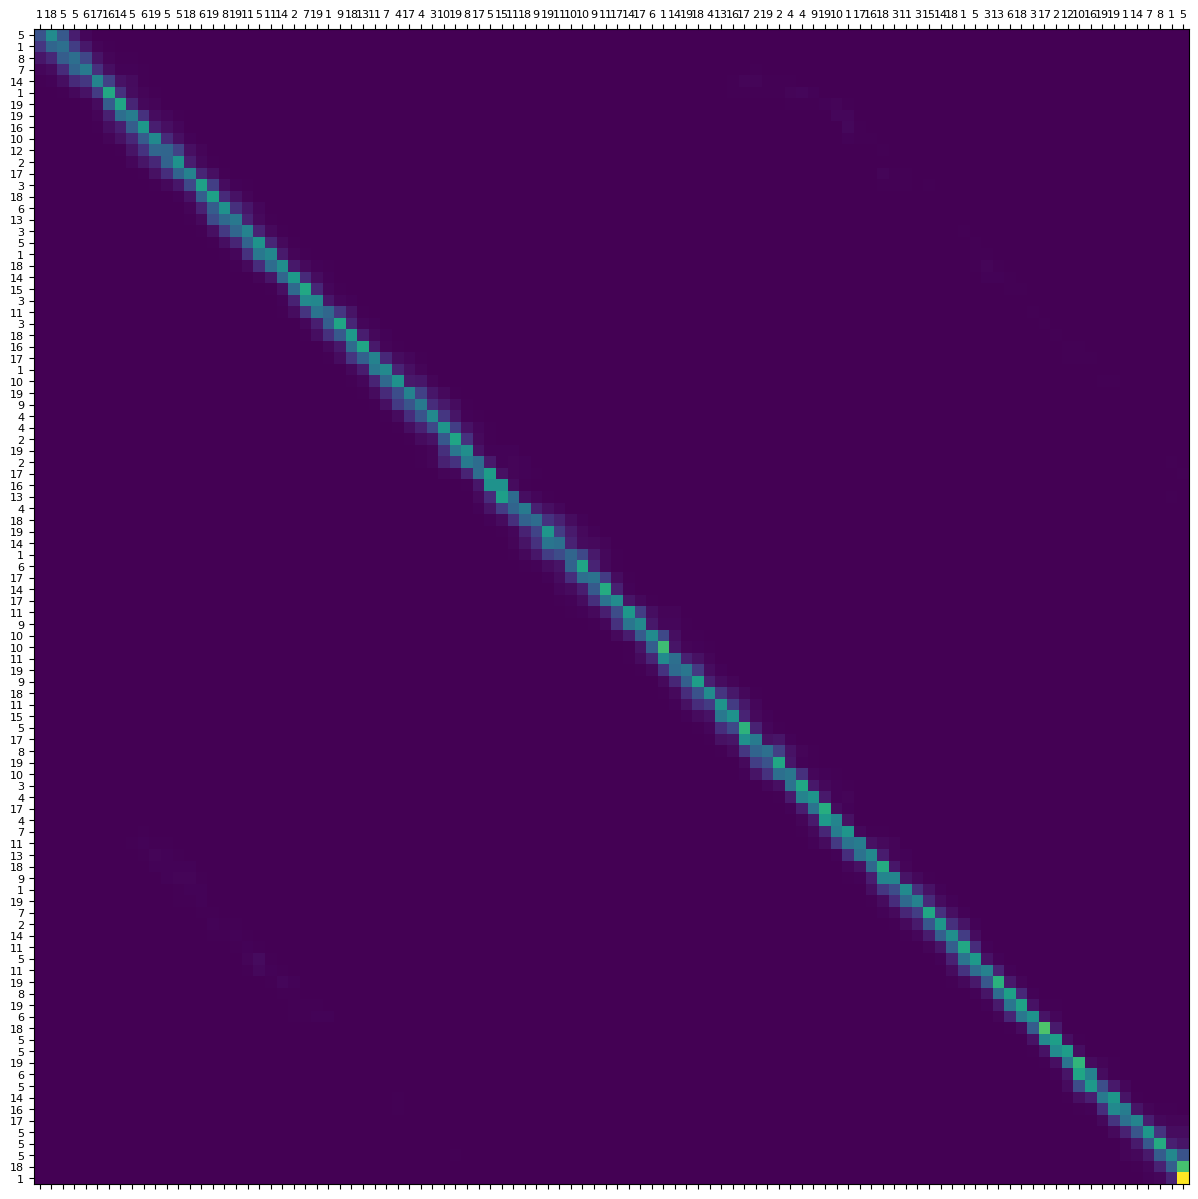

In [ ]:
inv_seq = generate_sequence(n_timesteps_in, n_features)
final_plot(inv_seq, encoder_lstm, decoder_lstm, decoder_dense, attention)

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization.


First of all, note that Bahdnanau Attention and Luong General Attention implementations were achieved by little changes on the previous Luong Dot Attention implementation; we basically change some initialization weights and the corresponding scores.

For the comparative, note that we did both three implementations with the same Dataset and with 200 epochs and 30 of patience each.

The results were the following:
The first Luong Dot Attention attempt: PREDICTION ACCURACY (%):
Train: 98.981, Test: 98.770

Bahdanau Attention: PREDICTION ACCURACY (%):
Train: 99.996, Test: 100.000

Luong General Attention: PREDICTION ACCURACY (%):
Train: 74.331, Test: 71.175

Luong Dot Attention:  PREDICTION ACCURACY (%):
Train: 99.279, Test: 98.165

Luong Dot early stopped with 153 epochs (in the second attempt) while in the first attempt didn't. Note also that the other ones (Bahdanau and Luong General) didn't early stop.

Finally, we have plotted the weights for each implementation. As expected seeing the the accuracy results, we have that the weighted matrices of Luong Dot Attention and Bahdanau Attention look like a diagonal matrix, that is, the best possible visualization. On the other hand, with Luong General Attention we get a "poorer" diagonal.  

As for this comparison, we can conlude that Bahdanau and Luong Dot attention are the best ones while the Luong General is the best. Luong General may need more epochs to improve its performance.


